# Corona-Impfungen in Deutschland: Verlauf und Prognose

Überblick über Fallzahlen auf Bundesland- und Landkreis-Ebene: https://experience.arcgis.com/experience/478220a4c454480e823b17327b2bf1d4

Übersichtliche Darstellung der wichtigsten Infos: https://www.corona-in-zahlen.de/

##### Überblick:
Hochrechnung der Bundesregierung über Impflieferungen (bisher unbestätigt): 18,5 Mio. in Q1 2021, 77 Mio. in Q2 2021, 125 Mio. in Q3 2021, 100 Mio. in Q4 2021 (https://twitter.com/MEtzold/status/1356249807229222913)


In [59]:
import csv
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import urllib.request
import requests
import matplotlib as mpl
import warnings
from bs4 import BeautifulSoup
from datetime import datetime
pd.options.mode.chained_assignment = None

from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#### Aktueller R-Wert:

In [60]:
r = requests.get("https://www.corona-in-zahlen.de/r-wert/")
doc = BeautifulSoup(r.text, "html.parser")
counter = 0
for card in doc.select(".row .card-title"):
    if counter == 0:
        counter += 1
    elif counter == 1:
        r_wert = card.text
    else:
        print("Problem: Veränderte Website!")
        
print("Aktueller R-Wert Deutschland (7-Tages Durchschnitt): " + str(r_wert))

Aktueller R-Wert Deutschland (7-Tages Durchschnitt): 1,16


## Bisheriger Verlauf der Impfkampagne:

In [61]:
# Einlesen der aktuellesten deutschlandweiten Zeitreihe (RKI)

r = urllib.request.urlopen("https://impfdashboard.de/static/data/germany_vaccinations_timeseries_v2.tsv")
data = r.read().decode().replace("\t",";")
file = open("data.txt", "w")
for line in data:
    file.write(line)
file.close()
data = pd.read_csv("data.txt", delimiter=";",header=0)

# Anpassen von Datentypen

pd.to_numeric(data["dosen_differenz_zum_vortag"], errors="coerce")
data["dosen_differenz_zum_vortag"].iloc[0] = 24080
datum = pd.to_datetime(data["date"])
data["date"] = datum
data.dtypes
data["date"] = data["date"].dt.strftime("%d.%m.%y")

days = np.arange(len(data))
impfungen_kumulativ = np.array(data["dosen_kumulativ"])
a = [0]
for i in impfungen_kumulativ:
    a.append(i)
b = np.array(a)
impfungen_kumulativ = np.append(impfungen_kumulativ,b[0])
c = impfungen_kumulativ - b
tägliche_impfungen = c[c>0]

data["tägliche_impfungen"] = tägliche_impfungen
data["tage_seit_impfstart"] = days
pd.options.display.max_columns = None

In [62]:
# Einlesen der aktuellsten Aufschlüsselung nach Bundesländern (RKI)

url = "https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Impfquotenmonitoring.xlsx;jsessionid=2E9CE964B41ED71B14C434A8B4C94A54.internet052?__blob=publicationFile"
r = requests.get(url)
with open('Impfquotenmonitoring.xlsx', 'wb') as outfile:
    outfile.write(r.content)
data2 = pd.read_excel("Impfquotenmonitoring.xlsx",sheet_name=1,header=[0,1])
data2.drop(data2.index[[0,17,18,19,20,21,22,23,24,25]],inplace=True)

def anzeige2(event):
    display(data2)
    
button_data2 = widgets.Button(description="Daten anzeigen")
display(button_data2)
button_data2.on_click(anzeige2)

Button(description='Daten anzeigen', style=ButtonStyle())

Geschätzter Bevölkerungsanteil, der für Herdenimmunität nötig ist:

In [63]:
input_herde = widgets.IntSlider(
    value=70,
    min=50,
    max=100,
    step=1,
    description='Eingabe (%):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

display(input_herde)

IntSlider(value=70, continuous_update=False, description='Eingabe (%):', min=50)

In [64]:
gruppe1 = 8000000 # 80 und älter
gruppe2 = 15630000 # 70 und älter
gruppe3 = 29340000 # 60 und älter
gruppe4 = 83157000 * 0.7

def use(event):
    global gruppe4
    herde = input_herde.value/100
    gruppe4 = int(round(83157000 * herde,0))
    print("Eingabe verwendet! Neuer Wert für Herdenimmunität: " + str(f"{gruppe4:,d}"))

button_herde = widgets.Button(description="Verwenden")
display(button_herde)
button_herde.on_click(use)

Button(description='Verwenden', style=ButtonStyle())

#### Impfgruppen nach Priorität
Quelle: https://www.bundesregierung.de/breg-de/themen/corona-informationen-impfung/corona-impfverordnung-1829940

- Gruppe 1: 80+ Jährige sowie wichtiges Gesundheitspersonal
- Gruppe 2: 70+ Jährige (sowie bestimmte Patientengruppen, hier nicht integriert)
- Gruppe 3: 60+ Jährige sowie Polizei/Feuerwehr/Lehrer/Erzieher
- Gruppe 4: Alle, Herdenimmunität hier als 70% der Gesamtbevölkerung berechnet

Quelle für Altersgruppen: https://www.destatis.de/DE/Presse/Pressemitteilungen/2020/12/PD20_N082_122.html

Schätzungen für Berufsgruppen:
- Wichtiges Gesundheitspersonal: 2,4 Millionen (https://www-genesis.destatis.de/genesis/online?sequenz=tabelleErgebnis&selectionname=23621-0001&zeitscheiben=10#abreadcrumb)
- Polizei (Vollzugsbeamte): 275.000 (https://www.welt.de/politik/deutschland/article170625072/Zahl-der-Polizisten-erreicht-neuen-Hoechststand.html#:~:text=Die%20Zahl%20der%20Polizisten%20in,noch%20%C3%BCber%2010.000%20Stellen%20weniger.)
- Feuerwehr: 33.000 (Hauptberuflich) + 97.000 (Freiwillig) (https://www.feuerwehrverband.de/presse/statistik/#:~:text=2018%20(2017)%20gab%20es%20in,und%20771%20(770)%20Werkfeuerwehren.)
- Lehrer: 800.000 (https://de.statista.com/statistik/daten/studie/201496/umfrage/anzahl-der-lehrer-in-deutschland-nach-bundeslaendern/#:~:text=In%20Deutschland%20gab%20es%20im,und%20Lehrerinnen%20an%20allgemeinbildenden%20Schulen)
- Erzieher: 785.000 (https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Soziales/Kindertagesbetreuung/Tabellen/beschaeftigte-merkmale-2018.html)

Damit ergeben sich folgende (ungefähren) Zahlen (kumuliert) für die Gruppenstärken:

| Impfgruppe | Kumulierte Anzahl |
|---|---|
| 1 | 8.000.000 |
| 1 + 2 | 15.630.000 |
| 1 + 2 + 3 | 29.340.000 |
| Herdenimmunität | 58.210.000 |

#### Sämtliche Daten:

In [65]:
stopper1 = []
def show_data(arg):
    if stopper1 == []:
        display(data)
        stopper1.append(1)
    else:
        pass

button = widgets.Button(description="Anzeigen")
display(button)
button.on_click(show_data)

Button(description='Anzeigen', style=ButtonStyle())



#### Letzter Tag der Aufzeichnungen:



In [66]:
stopper2 = []
def show_last(arg):
    if stopper2 == []:
        latest = data.iloc[-1]
        print(latest)
        stopper2.append(1)
    else:
        pass

button = widgets.Button(description="Anzeigen")
display(button)
button.on_click(show_last)

Button(description='Anzeigen', style=ButtonStyle())

#### Grafische Darstellung des bisherigen Verlaufs

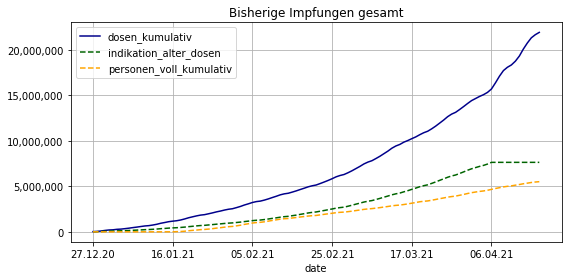

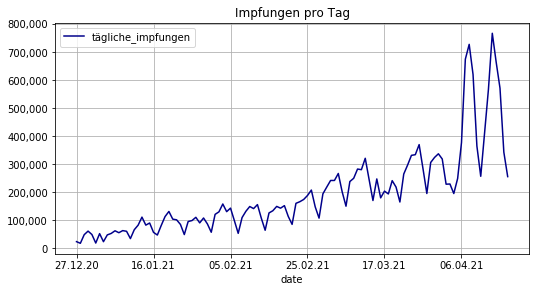

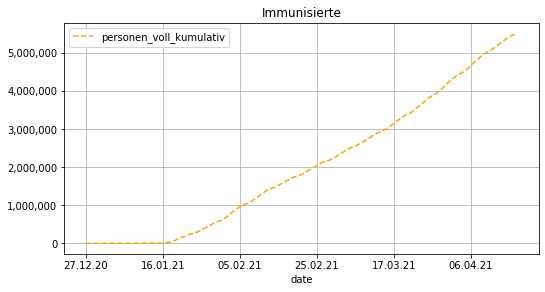

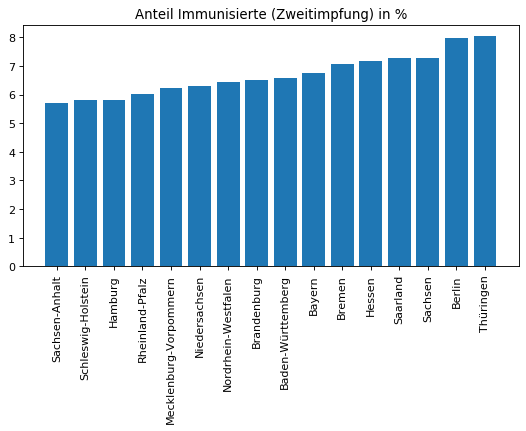

In [67]:
%matplotlib inline
ax=data.plot(kind="line", x="date", y="dosen_kumulativ", color="DarkBlue", figsize=(8, 4))
ax2=data.plot(kind="line", x="date", y="indikation_alter_dosen", linestyle="dashed", color="DarkGreen",ax=ax)
ax=data.plot(kind="line",x="date",y="personen_voll_kumulativ", linestyle="dashed", color="Orange",ax=ax)
plt.title("Bisherige Impfungen gesamt")
plt.grid(True)
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#plt.axhline(y=gruppe1, label="Gruppe 1")
plt.tight_layout()
plt.show()

ax=data.plot(kind="line", x="date", y="tägliche_impfungen", color="DarkBlue", figsize=(8.5, 4.25))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Impfungen pro Tag")
plt.grid(True)
plt.show()

ax=data.plot(kind="line",x="date",y="personen_voll_kumulativ", linestyle="dashed", color="Orange", figsize=(8.5, 4.25))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Immunisierte")
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(8, 4), dpi=80)
#data2['Bevölkerung'] = data2.iloc[:,2]/(data2.iloc[:,7]/100)
data2['Zweitimpfung_quote'] = data2.iloc[:,8]
data2.sort_values(by="Zweitimpfung_quote",inplace=True)
plt.bar(x=data2.iloc[:,1],height=data2['Zweitimpfung_quote'])
plt.xticks(x=data2.iloc[:,1], rotation='vertical')
plt.title('Anteil Immunisierte (Zweitimpfung) in %')
plt.show()

## Prognosen über zukünftige Entwicklungen

#### Wichtiger Hinweis: 
Zahlen über Immunisierte werden als Dosen/2 berechnet, was aufgrund der verzögerten Zweitimpfung nicht ganz korrekt ist (für längere Zeithorizonte jedoch recht akkurat sein sollte).

##### Moving Average Prognose (bis August 2021)
Berechnung mittels des gleitenden Durchschnitts der täglichen Impfungen der letzten 7 Tage

In [68]:
dates_future = pd.date_range(start='2020-12-27', end='2021-8-1')
reps= len(dates_future)

 
Durchschnittliche Tagesimpfungen der letzten 7 Tage: 511,800



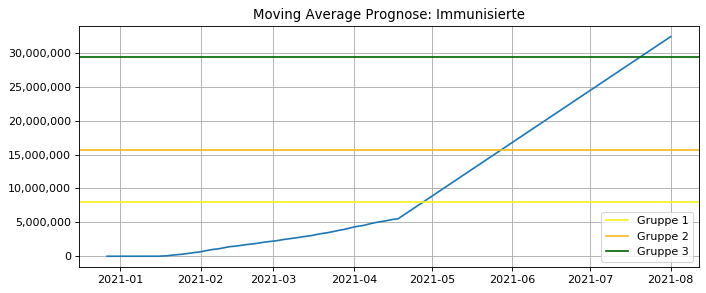


Immunisierte bis August 2021: 32,386,782
Benötigte Impfdosen bis August 2021: 64,773,564


In [69]:
warnings.filterwarnings("ignore",category=mpl.cbook.mplDeprecation)

rolling_mean = round(data["dosen_differenz_zum_vortag"].rolling(window=7).mean().iloc[-1],-2)

print(" ")
print("Durchschnittliche Tagesimpfungen der letzten 7 Tage: " + str(f"{int(rolling_mean):,d}"))

prognose = list(data["personen_voll_kumulativ"])
while len(prognose) < reps:
    prognose.append(prognose[-1]+rolling_mean/2)

print("")
fig = plt.figure(figsize=(10, 4), dpi=80)
plt.grid(True)
plt.title("Moving Average Prognose: Immunisierte")
ax1 = fig.add_subplot(111)
lines = ax1.plot(dates_future, prognose)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
if prognose[-1] > gruppe1 - 1000000:
    plt.axhline(y=gruppe1, label="Gruppe 1", color="#f5f11d")
if prognose[-1] > gruppe2 - 1000000:
    plt.axhline(y=gruppe2, label="Gruppe 2", color="#f5bb1d")
if prognose[-1] > gruppe3 - 1000000:
    plt.axhline(y=gruppe3, label="Gruppe 3", color="DarkGreen")
plt.legend()
plt.show()
print("")

prognose_end = round(prognose[-1])
print("Immunisierte bis August 2021: " + str(f"{prognose_end:,d}"))
prognose_end = round(prognose[-1])
print("Benötigte Impfdosen bis August 2021: " + str(f"{prognose_end*2:,d}"))

##### Manuelle Prognose (bis Ende 2021)

Benötigte Eingabe: Geschätzte Impfungen pro Tag für die 4 Quartale des Jahres 2021

IntText(value=300000, description='2. Quartal')

IntText(value=400000, description='3. Quartal')

IntText(value=500000, description='4. Quartal')

Button(description='Simulieren', style=ButtonStyle())



Prognose für 300,000 im 2.Quartal | 400,000 im 3.Quartal | 500,000 im 4.Quartal.



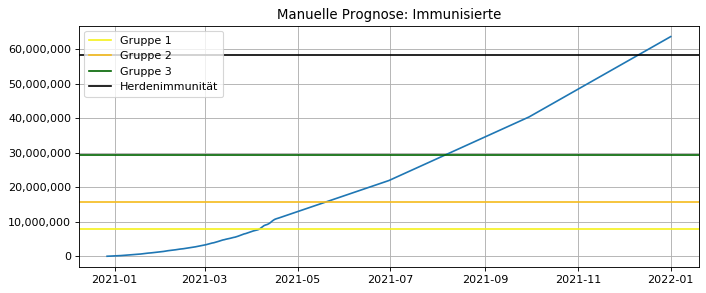


Immunisierte bis Januar 2022: 63,572,854
Benötigte Impfdosen bis Januar 2022: 127,145,707





In [70]:
dates_future = pd.date_range(start='2020-12-27', end='2022-1-1')
reps= len(dates_future)

input_Q2 = widgets.IntText(description="2. Quartal", value=300000)
input_Q3 = widgets.IntText(description="3. Quartal", value=400000)
input_Q4 = widgets.IntText(description="4. Quartal", value=500000)
display(input_Q2)
display(input_Q3)
display(input_Q4)


start = datetime(2019,12,27)
now = len(data)
Q1 = datetime(2020,3,31)
Q2 = datetime(2020,6,30)
Q3 = datetime(2020,9,30)
Q4 = datetime(2020,12,31)

days_future = list(range(0,reps))

def klick(event):
    prognose2 = list(data["dosen_kumulativ"])
    days_left = len(days_future) - len(days)
    days_future2 = list(range(0,days_left))
    value = prognose2[-1]
    for i in days_future2:
        if i < ((Q1 - start).days - now):
            tägliche_impfungen_geschätzt = 290000
        elif i < ((Q2 - start).days - now):
            tägliche_impfungen_geschätzt = input_Q2.value
        elif i < ((Q3 - start).days - now):
            tägliche_impfungen_geschätzt = input_Q3.value
        elif i <= ((Q4 - start).days - now):
            tägliche_impfungen_geschätzt = input_Q4.value
        else:
            print("Problem bei der Simulation: Code überprüfen!")
        value += tägliche_impfungen_geschätzt
        prognose2.append(value)
    prognose2 = [i/2 for i in prognose2]
    print("")
    print("")
    print("Prognose für " 
          + str(f"{input_Q2.value:,d}") + " im 2.Quartal | "
          + str(f"{input_Q3.value:,d}") + " im 3.Quartal | "
          + str(f"{input_Q4.value:,d}") + " im 4.Quartal.")
    print("")
    fig = plt.figure(figsize=(10, 4), dpi=80)
    plt.grid(True)
    plt.title("Manuelle Prognose: Immunisierte")
    ax1 = fig.add_subplot(111)
    lines = ax1.plot(dates_future, prognose2)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.axhline(y=gruppe1, label="Gruppe 1", color="#f5f11d")
    plt.axhline(y=gruppe2, label="Gruppe 2", color="#f5bb1d")
    plt.axhline(y=gruppe3, label="Gruppe 3", color="DarkGreen")
    plt.axhline(y=gruppe4, label="Herdenimmunität", color="Black")
    plt.legend(loc='upper left')
    plt.show()
    print("")
    prognose_end = round(prognose2[-1])
    print("Immunisierte bis Januar 2022: " + str(f"{prognose_end:,d}"))
    prognose_end = round(prognose2[-1]*2)
    print("Benötigte Impfdosen bis Januar 2022: " + str(f"{prognose_end:,d}"))
    print("")
    print("")
    print("")
    
button = widgets.Button(description="Simulieren")
display(button)
button.on_click(klick)